In [19]:
from data_mining import data
d=data()

11it [00:11,  1.03s/it]


In [20]:
dataset=d.merge_whole_dataset()

100%|██████████| 14/14 [00:00<00:00, 134.98it/s]


In [21]:
dataset.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,Shortcut,Population_using_at_least_basic_sanitation_services_(%),Hospital_beds_(per_10_000_population),Total_expenditure_on_health_as_a_percentage_of_gross_domestic_product,...,Nursing_and_midwifery_personnel_(per_10_000_population),Skilled_health_professionals_density_(per_10_000_population),Prevalence_of_smoking_any_tobacco_product_among_persons_aged_>=_15_years,Raised_fasting_blood_glucose_(>=7.0_mmol/L_or_on_medication)(age-standardized_estimate),Raised_blood_pressure_(SBP>=140_OR_DBP>=90)_(age-standardized_estimate),"Prevalence_of_obesity_among_adults,_BMI_>=_30_(age-standardized_estimate)_(%)",Health_Service_Provision,Population ages 65 and above,Pop,Pop_dens
0,1,NaN,Afghanistan,2020-01-22,0,0,AFG,62.26144,5.3,8.18227,...,6037.0,6.37,NaN,11.9,30.6,3.2,60.0,2.584927,37172386.0,56.93776
1,2,NaN,Afghanistan,2020-01-23,0,0,AFG,62.26144,5.3,8.18227,...,6037.0,6.37,NaN,11.9,30.6,3.2,60.0,2.584927,37172386.0,56.93776
2,3,NaN,Afghanistan,2020-01-24,0,0,AFG,62.26144,5.3,8.18227,...,6037.0,6.37,NaN,11.9,30.6,3.2,60.0,2.584927,37172386.0,56.93776
3,4,NaN,Afghanistan,2020-01-25,0,0,AFG,62.26144,5.3,8.18227,...,6037.0,6.37,NaN,11.9,30.6,3.2,60.0,2.584927,37172386.0,56.93776
4,5,NaN,Afghanistan,2020-01-26,0,0,AFG,62.26144,5.3,8.18227,...,6037.0,6.37,NaN,11.9,30.6,3.2,60.0,2.584927,37172386.0,56.93776


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp

%matplotlib inline

In [30]:
# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
    
    S, E, I, R = y
    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)
    return [S_out, E_out, I_out, R_out]

N = 100000  # Population size
n_infected = 1
max_days = 200

# State at time = 0 for SEIR model
a = (N - n_infected)/ N
b = 0
c = n_infected / N
d = 0.

In [31]:
def plot_model(solution, title='SEIR model'):
    sus, exp, inf, rec = solution.y

    f = plt.figure(figsize=(8,5)) 
    plt.plot(sus, 'b', label='Susceptible');
    plt.plot(exp, 'y', label='Exposed');
    plt.plot(inf, 'r', label='Infected');
    plt.plot(rec, 'c', label='Recovered/deceased');
    plt.title(title)
    plt.xlabel("Days", fontsize=10);
    plt.ylabel("Fraction of population", fontsize=10);
    plt.legend(loc='best');

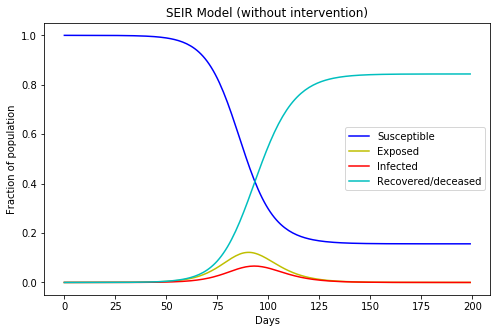

In [34]:
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.2  # reproduction number

#sol = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d], args=(R_0, T_inf, T_inc), 
#                t_eval=np.arange(max_days))
sol = solve_ivp(fun=lambda t,y:SEIR_model(t, y, R_0, T_inf, T_inc),t_span=[0, max_days],y0=[a, b, c, d], t_eval=np.arange(max_days))


plot_model(sol, 'SEIR Model (without intervention)')

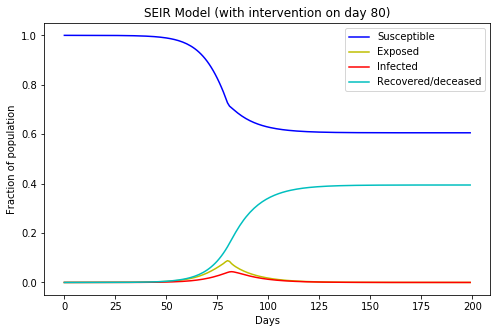

In [38]:
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.2  # reproduction number without intervention
R_t = 0.7  # reproduction number after intervention
intervention_day = 80

def time_varying_reproduction(t):
    if t > intervention_day:
        return R_t
    else:
        return R_0

sol2 = solve_ivp(fun=lambda t,y:SEIR_model(t, y, time_varying_reproduction, T_inf, T_inc),t_span=[0, max_days],y0=[a, b, c, d], t_eval=np.arange(max_days))

plot_model(sol2, f'SEIR Model (with intervention on day {intervention_day})')

In [ ]:
# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr = params
    N = population
    n_infected = data['ConfirmedCases'].iloc[0]
    max_days = len(data) + forecast_days
    a, b, c, d = (N - n_infected)/ N, 0, n_infected / N, 0
               
    sol2 = solve_ivp(fun=lambda t,y:SEIR_model(t, y, time_varying_reproduction, T_inf, T_inc),t_span=[0, max_days],y0=[a, b, c, d], t_eval=np.arange(max_days))
    
    y_pred_cases = np.diff((sol.y[2] + sol.y[3])*N, prepend=n_infected).cumsum()
    y_pred_cases = np.clip(y_pred_cases, 0, np.inf)